In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r'D:\Project Pattern\archive\chest_xray'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.01)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#imshow(out, title=[class_names[x] for x in classes])

In [4]:
from tqdm import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    all_losses_train = []
    all_losses_val = []
    all_acc_train = []
    all_acc_val = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                
                optimizer.zero_grad()

                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            

            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                all_losses_train.append(epoch_loss)
                all_acc_train.append(epoch_acc)
            else:
                all_losses_val.append(epoch_loss)
                all_acc_val.append(epoch_acc)
            
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, all_losses_train, all_acc_train, all_losses_val, all_acc_val

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features


model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.005, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
###TRAINING

model_ft, all_losses_train, all_acc_train, all_losses_val, all_acc_val = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.6956 Acc: 0.7485


  5%|▌         | 1/20 [01:11<22:47, 71.95s/it]

val Loss: 0.7728 Acc: 0.7997

Epoch 1/19
----------
train Loss: 0.5567 Acc: 0.7768


 10%|█         | 2/20 [02:22<21:22, 71.25s/it]

val Loss: 0.4266 Acc: 0.8285

Epoch 2/19
----------
train Loss: 0.4545 Acc: 0.8173


 15%|█▌        | 3/20 [03:34<20:15, 71.47s/it]

val Loss: 0.3995 Acc: 0.8558

Epoch 3/19
----------
train Loss: 0.4450 Acc: 0.8230


 20%|██        | 4/20 [04:46<19:06, 71.68s/it]

val Loss: 0.4950 Acc: 0.8349

Epoch 4/19
----------
train Loss: 0.3838 Acc: 0.8518


 25%|██▌       | 5/20 [05:58<17:57, 71.83s/it]

val Loss: 0.3368 Acc: 0.8702

Epoch 5/19
----------
train Loss: 0.3644 Acc: 0.8602


 30%|███       | 6/20 [07:09<16:43, 71.65s/it]

val Loss: 0.5584 Acc: 0.8654

Epoch 6/19
----------
train Loss: 0.3207 Acc: 0.8771


 35%|███▌      | 7/20 [08:22<15:34, 71.89s/it]

val Loss: 0.3781 Acc: 0.8622

Epoch 7/19
----------
train Loss: 0.2497 Acc: 0.8980


 40%|████      | 8/20 [09:34<14:23, 71.96s/it]

val Loss: 0.3788 Acc: 0.8798

Epoch 8/19
----------
train Loss: 0.2266 Acc: 0.9093


 45%|████▌     | 9/20 [10:46<13:12, 72.04s/it]

val Loss: 0.3865 Acc: 0.8638

Epoch 9/19
----------
train Loss: 0.2192 Acc: 0.9114


 50%|█████     | 10/20 [11:59<12:02, 72.23s/it]

val Loss: 0.3475 Acc: 0.8926

Epoch 10/19
----------
train Loss: 0.2095 Acc: 0.9155


 55%|█████▌    | 11/20 [13:10<10:48, 72.06s/it]

val Loss: 0.3870 Acc: 0.8878

Epoch 11/19
----------
train Loss: 0.2192 Acc: 0.9143


 60%|██████    | 12/20 [14:22<09:35, 71.94s/it]

val Loss: 0.4140 Acc: 0.8558

Epoch 12/19
----------
train Loss: 0.2047 Acc: 0.9176


 65%|██████▌   | 13/20 [15:33<08:22, 71.73s/it]

val Loss: 0.3481 Acc: 0.8862

Epoch 13/19
----------
train Loss: 0.2093 Acc: 0.9179


 70%|███████   | 14/20 [16:45<07:10, 71.75s/it]

val Loss: 0.4241 Acc: 0.8734

Epoch 14/19
----------
train Loss: 0.1940 Acc: 0.9235


 75%|███████▌  | 15/20 [17:56<05:58, 71.62s/it]

val Loss: 0.3764 Acc: 0.8814

Epoch 15/19
----------
train Loss: 0.1917 Acc: 0.9250


 80%|████████  | 16/20 [19:09<04:47, 71.84s/it]

val Loss: 0.3407 Acc: 0.8926

Epoch 16/19
----------
train Loss: 0.1881 Acc: 0.9273


 85%|████████▌ | 17/20 [20:23<03:37, 72.63s/it]

val Loss: 0.3744 Acc: 0.8766

Epoch 17/19
----------
train Loss: 0.1971 Acc: 0.9229


 90%|█████████ | 18/20 [21:36<02:25, 72.69s/it]

val Loss: 0.3393 Acc: 0.8926

Epoch 18/19
----------
train Loss: 0.1876 Acc: 0.9262


 95%|█████████▌| 19/20 [22:47<01:12, 72.29s/it]

val Loss: 0.3422 Acc: 0.8942

Epoch 19/19
----------
train Loss: 0.1810 Acc: 0.9310


100%|██████████| 20/20 [23:59<00:00, 71.99s/it]

val Loss: 0.3619 Acc: 0.8830

Training complete in 24m 1s
Best val Acc: 0.894231


In [9]:
#SAVE MODEL BEST
torch.save(model_ft.state_dict(), 'resnet18_fulltrain.pth')


In [10]:
def test_model(model, criterion, optimizer, scheduler, num_epochs=1):
    since = time.time()
    predictions=[]
    labels_all=[]
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        
        for phase in ['val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                
                optimizer.zero_grad()

                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    predictions.extend(preds.cpu().data.numpy().tolist())
                    labels_all.extend(labels.cpu().data.numpy().tolist())

                    loss = criterion(outputs, labels)

                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    
    print('Best val Acc: {:4f}'.format(best_acc))

    
    return predictions, labels_all

In [11]:

model_ft.load_state_dict(torch.load('resnet18_fulltrain.pth'))
output_test = test_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=1)




Epoch 0/0
----------
val Loss: 0.3422 Acc: 0.8942

Best val Acc: 0.894231


In [12]:
from sklearn.metrics import classification_report

print(classification_report(output_test[1], output_test[0]))

              precision    recall  f1-score   support

           0       0.96      0.75      0.84       234
           1       0.87      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



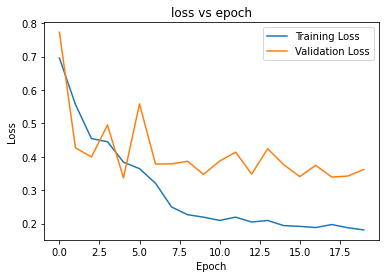

In [23]:
#PLOTTING LOSSES AND ACCURACY vs EPOCHS
import matplotlib.pyplot as plt

x=np.arange(0,20)
plt.figure()
plt.plot(x,all_losses_train, label='Training Loss')
plt.plot(x,all_losses_val, label='Validation Loss')
plt.title('loss vs epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [ ]:
#print(all_acc_train)

acc_train=np.zeros(len(all_acc_train))
acc_val=np.zeros(len(all_acc_val))

for i in range(len(all_acc_train)):
    acc_train[i]=all_acc_train[i].item()
    acc_val[i]=all_acc_val[i].item()



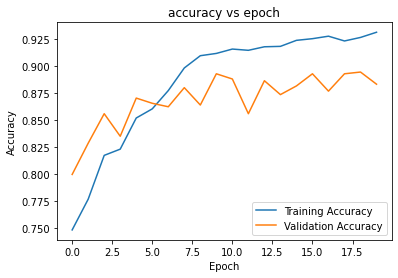

In [30]:

plt.figure()
plt.plot(x,acc_train, label='Training Accuracy')
plt.plot(x,acc_val, label='Validation Accuracy')
plt.title('accuracy vs epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
